In [1]:
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

2024-08-13 17:33:36.781112: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 17:33:36.781143: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 17:33:36.782322: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-13 17:33:36.789847: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-13 17:33:37.506680: W tensorflow/compiler/tf2

In [6]:
algorithm = 'BunDLeNet'
rat_name = 'gatsby'

file_pattern = f'../../data/generated/saved_Y/{{}}__{algorithm}_rat_{rat_name}'
y0_tr = np.loadtxt(file_pattern.format('y0_tr'))
y1_tr = np.loadtxt(file_pattern.format('y1_tr'))
y0_tst = np.loadtxt(file_pattern.format('y0_tst'))
y1_tst = np.loadtxt(file_pattern.format('y1_tst'))
b_train_1 = np.loadtxt(file_pattern.format('b_train_1'))
b_test_1 = np.loadtxt(file_pattern.format('b_test_1'))

y0_tr = y0_tr.reshape(y0_tr.shape[0],-1)
y1_tr = y1_tr.reshape(y1_tr.shape[0],-1)
y0_tst = y0_tst.reshape(y0_tst.shape[0],-1)
y1_tst = y1_tst.reshape(y1_tst.shape[0],-1)
ydiff_tr = y1_tr - y0_tr
ydiff_tst = y1_tst - y0_tst

In [30]:
%matplotlib notebook
window_size = 25
moving_average = np.convolve(ydiff_tr[:,0], np.ones(window_size)/window_size, mode='valid')
plt.figure()
# plt.plot(ydiff_tr[:,0])
plt.plot(y0_tr[:,0]/100)
plt.plot(np.arange(window_size,moving_average.shape[0]+window_size), moving_average)
plt.hlines(y=0, xmin=0, xmax=moving_average.shape[0])
plt.show()

<IPython.core.display.Javascript object>

In [40]:
%matplotlib notebook
plt.figure()
plt.scatter(y0_tr[:,2], ydiff_tr[:,2])
plt.plot(np.linspace(-.5,.5,5), np.linspace(-.5,.5,5))
plt.show()

<IPython.core.display.Javascript object>

In [13]:
%matplotlib notebook
plt.figure()
plt.plot(y0_tr[:,0])
plt.plot(ydiff_tr[:,0])
plt.show()

<IPython.core.display.Javascript object>

In [8]:
### Scaling input and output data
yinmax = (np.abs(y0_tr)).max() # Parameters for scaling
y0_tr, y0_tst = y0_tr/yinmax, y0_tst/yinmax
ydmax = (np.abs(ydiff_tr)).max() # Parameters for scaling
ydiff_tr, ydiff_tst = ydiff_tr/ydmax, ydiff_tst/ydmax

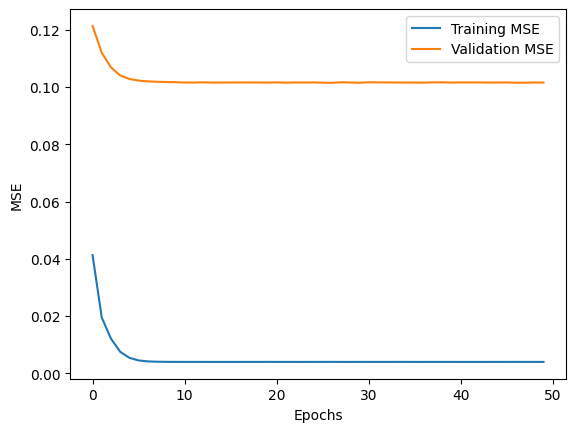

(14577, 3)
(14577, 3)
0.00043569697796306677
0.0004165603278882858
0.010701387499151211
0.010600954949490043


In [9]:

# Defining the model
model_ydiff_f_yt = tf.keras.Sequential([
	tf.keras.layers.Dense(3, activation='linear')])
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
model_ydiff_f_yt.compile(optimizer=opt,
			  loss='mse',
			  metrics=['mse'])

history = model_ydiff_f_yt.fit(y0_tr,
					  ydiff_tr,
					  epochs=50,
					  batch_size=1000,
					  validation_data=(y0_tst, ydiff_tst),
					  verbose=0
					  )
plt.figure()
plt.plot(history.history['mse'], label='Training MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.show()

# Predictions
ydiff_tr_pred = model_ydiff_f_yt(y0_tr).numpy()
ydiff_tst_pred = model_ydiff_f_yt(y0_tst).numpy()

# Inverse scaling the data
ydiff_tr_pred, ydiff_tr, y0_tr = ydiff_tr_pred*ydmax, ydiff_tr*ydmax, y0_tr*yinmax
ydiff_tst_pred, ydiff_tst, y0_tst = ydiff_tst_pred*ydmax, ydiff_tst*ydmax, y0_tst*yinmax

y1_tr_pred = y0_tr + ydiff_tr_pred
y1_tst_pred = y0_tst + ydiff_tst_pred

# Evaluation
flat_partial = lambda x: x.reshape(x.shape[0],-1)
print(y1_tr.shape)
baseline_tr  = mean_squared_error(flat_partial(y1_tr), flat_partial(y0_tr))
modelmse_tr = mean_squared_error(flat_partial(y1_tr), flat_partial(y1_tr_pred))
baseline_tst  = mean_squared_error(flat_partial(y1_tst), flat_partial(y0_tst))
modelmse_tst = mean_squared_error(flat_partial(y1_tst), flat_partial(y1_tst_pred))
print(y1_tr.shape)

print(baseline_tr)
print(modelmse_tr)
print(baseline_tst)
print(modelmse_tst)


In [31]:
y1_tr.shape

(14577, 3)

In [8]:
### Dynamics predictability evaluation
mse_list = []
for i in tqdm(np.arange(10)):
	### Scaling input and output data
	yinmax = (np.abs(y0_tr)).max() # Parameters for scaling
	y0_tr, y0_tst = y0_tr/yinmax, y0_tst/yinmax
	ydmax = (np.abs(ydiff_tr)).max() # Parameters for scaling
	ydiff_tr, ydiff_tst = ydiff_tr/ydmax, ydiff_tst/ydmax

	# Defining the model
	model_ydiff_f_yt = tf.keras.Sequential([
		tf.keras.layers.Dense(3, activation='linear')])
	opt = tf.keras.optimizers.Adam(learning_rate=0.01)
	model_ydiff_f_yt.compile(optimizer=opt,
				  loss='mse',
				  metrics=['mse'])

	history = model_ydiff_f_yt.fit(y0_tr,
						  ydiff_tr,
						  epochs=50,
						  batch_size=1000,
						  validation_data=(y0_tst, ydiff_tst),
						  verbose=0
						  )

	# Predictions
	ydiff_tr_pred = model_ydiff_f_yt(y0_tr).numpy()
	ydiff_tst_pred = model_ydiff_f_yt(y0_tst).numpy()

	# Inverse scaling the data
	ydiff_tr_pred, ydiff_tr, y0_tr = ydiff_tr_pred*ydmax, ydiff_tr*ydmax, y0_tr*yinmax
	ydiff_tst_pred, ydiff_tst, y0_tst = ydiff_tst_pred*ydmax, ydiff_tst*ydmax, y0_tst*yinmax

	y1_tr_pred = y0_tr + ydiff_tr_pred
	y1_tst_pred = y0_tst + ydiff_tst_pred

	# Evaluation
	flat_partial = lambda x: x.reshape(x.shape[0],-1)
	baseline_tr  = mean_squared_error(flat_partial(y1_tr), flat_partial(y0_tr))
	modelmse_tr = mean_squared_error(flat_partial(y1_tr), flat_partial(y1_tr_pred))
	baseline_tst  = mean_squared_error(flat_partial(y1_tst), flat_partial(y0_tst))
	modelmse_tst = mean_squared_error(flat_partial(y1_tst), flat_partial(y1_tst_pred))
	print(baseline_tr)
	print(modelmse_tr)
	print(baseline_tst)
	print(modelmse_tst)


	mse_list.append([baseline_tr, modelmse_tr, baseline_tst, modelmse_tst])


 10%|█         | 1/10 [00:01<00:15,  1.74s/it]

0.00043569697796306677
0.00041530758252533397
0.010701387499151211
0.010604781844476968


 20%|██        | 2/10 [00:03<00:13,  1.74s/it]

0.00043569697796306677
0.0004150136981635056
0.010701387499151211
0.010603675283082835


 30%|███       | 3/10 [00:05<00:11,  1.69s/it]

0.00043569697796306677
0.00041459832568377115
0.010701387499151211
0.010601142235928623


 40%|████      | 4/10 [00:06<00:09,  1.66s/it]

0.00043569697796306677
0.000414918305688604
0.010701387499151211
0.010602074132628404


 50%|█████     | 5/10 [00:08<00:08,  1.70s/it]

0.00043569697796306677
0.0004154876808619419
0.010701387499151211
0.010599577301041059


 60%|██████    | 6/10 [00:10<00:06,  1.69s/it]

0.00043569697796306677
0.0004154624974138364
0.010701387499151211
0.010604592795736214


 60%|██████    | 6/10 [00:10<00:06,  1.73s/it]


KeyboardInterrupt: 

In [ ]:

# Saving the metrics
mse_list = np.array(mse_list)
np.savetxt('../data/generated/evaluation_metrics/mse_list_' + algorithm + '_rat_' +  str(rat_name), mse_list)
